# RBS with 10,10 neurons 

In [1]:
%matplotlib inline
import sys
sys.path.append('/Users/mehdi/Dropbox/github/DESILSS')
import numpy as np
import matplotlib.pyplot as plt
import nn

/Users/mehdi/anaconda3/envs/py3p6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# for reading files
from glob import glob

In [5]:
import fitsio as ft
import healpy as hp
def hpixsum(nside, ra, dec, value=None, nest=False):
    '''
        make a healpix map from ra-dec
        hpixsum(nside, ra, dec, value=None, nest=False)
    '''
    pix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra), nest=nest)
    npix = hp.nside2npix(nside)
    w = np.bincount(pix, weights=value, minlength=npix)
    return w


In [6]:
#
ranmap = ft.read('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits')
path2cats = '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

#path4nofz = path2cats+'nofz'
#path4nofz = path2cats+'nofz_woSSR'
#path4nofz = path2cats+'nofz_21and22'
analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              zlim=(0.6,1.1),
              nmesh=256,
             )
gal = []
for i in [1, 2]:
    gal.append(ft.read(g(str(i)), lower=True, columns=kwargs['galcolnames']))
gal = np.concatenate(gal)
galmask = (gal['sector_tsr'] > kwargs['tsrmin']) & (gal['sector_ssr'] > kwargs['ssrmin'])
galmask &= (gal['z'] > kwargs['zlim'][0]) & (gal['z'] < kwargs['zlim'][1])
galmask &= (gal['z_reliable']) & (~gal['isdupl'])
gal = gal[galmask]
galm = hpixsum(256, gal['ra'], gal['dec'])

In [7]:
selection_rbs = ft.read('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/selection_rbsfit.fits')

In [8]:
selection_rbs[selection_rbs!=0.0]

array([0.9714591, 0.9714591, 0.9714591, ..., 0.9714591, 0.9714591,
       0.9714591])

In [12]:
sf = galm[ranmap>0.2].sum()/ranmap[ranmap>0.2].sum()
nranbar = 10000 * hp.nside2pixarea(256, degrees=True)
sf, nranbar

(0.01869545196348397, 524.5585282569792)

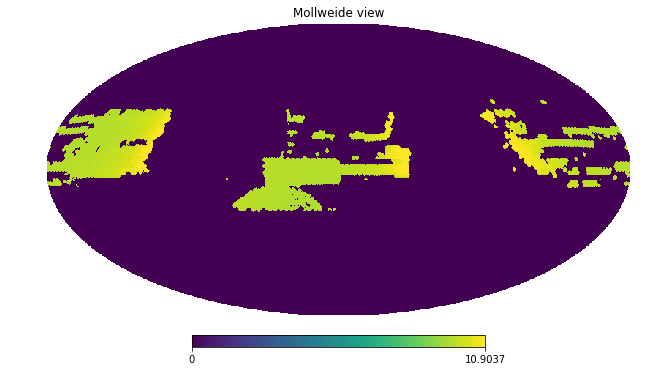

In [14]:
ngalfrac_linfit = selection_rbs * sf * nranbar
hp.mollview(ngalfrac_linfit)

(array([1226., 6568.,  874.,  499.,  308.,  242.,  205.,  161.,  152.,
         516.]),
 array([ 9.52696217,  9.66463708,  9.80231199,  9.93998689, 10.0776618 ,
        10.21533671, 10.35301162, 10.49068653, 10.62836143, 10.76603634,
        10.90371125]),
 <a list of 10 Patch objects>)

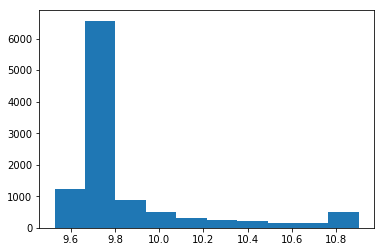

In [15]:
plt.hist(ngalfrac_linfit[ranmap>0.0])

In [ ]:
# read the raw input ie. Ngal normed by fracgood & #R-band BS as features
#
# we run this block ONCE to generate samples
data = np.load('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngalfracgoodf8-rbs-eboss21p2.npy')
Data4fold = nn.split2kfolds(data, k=4)
nn.write("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/inputs/",
         "ngalfracgoodf8-rbs-eboss21p2-4fold", Data4fold, fmt='npy')

In [3]:
#
# read the prepared input for the network, k-fold
# 
dfile = np.load("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/"\
                +"NN/inputs/ngalfracgoodf8-rbs-eboss21p2-4fold.npy")
data4fold = dfile.item()

We start off with a 3x3 network over all folds, to identify the best fold to explore. 

In [7]:
address = "/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/"
config = {'nchain':5, 'nepoch':2000, 'batchsize':200, 'Units':(3,3), 'learning_rate':.001}
for i in range(1,4): # fold0 is processed before
    fold = 'fold'+str(i)
    print(fold, ' is being processed')
    nn.run_nchainlearning(address+fold+'/',
                   data4fold['train'][fold], 
                   data4fold['test'][fold],
                  **config)

fold1  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
output is saved as reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold1/
fold2  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
output is saved as reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold2/
fold3  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
output is saved as reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold3/


In [9]:
files = glob("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold*/"\
             +"reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz")
files

['/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold0/reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold1/reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold2/reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold3/reg-nepoch2000-nchain5-batchsize200units33-Lrate0.001.npz']

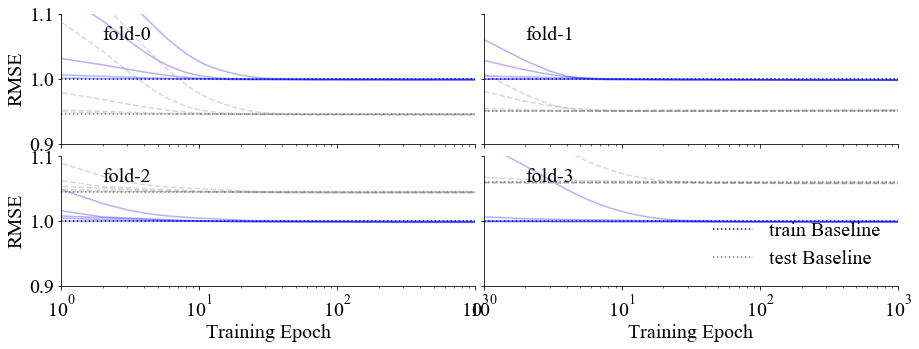

In [27]:
plt.rc('font', size=20, family='Times New Roman')
plt.rc('axes.spines', right=False, top=False)
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)
ax = ax.flatten()
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=out['options']['baselineRMSE'][0],
                         linestyles=':', label='train Baseline', alpha=1., color='blue')
            ax[j].hlines(xmin=1,xmax=3000,y=out['options']['baselineRMSE'][1],
                         linestyles=':', label='test Baseline', alpha=1., color='grey')

        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.3)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.3)
    ax[j].set_xscale('log')
    ax[j].text(0.1, 0.8, "fold-"+str(j), transform=ax[j].transAxes)
    if j == 3:ax[j].legend(frameon=False, loc='lower right')
    ax[j].set_ylim(0.9, 1.1)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    ax[j].set_xlim(1, 1000)

In [29]:
d     = np.load(files[0])
out   = d['arr_0'].item()
meanY, stdY = out['options']['stats']['ystat']
Xtrue = out['test'][1]
Ytrue = (out['test'][2].squeeze() - meanY) / stdY
y_avg = []
for i in range(len(out['chain_y'])):
    y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
Ypred = np.mean(np.array(y_avg), axis=0)

In [21]:
ypredlinfit = ngalfrac_linfit[hpix]

In [22]:
ypredlinfit_s = (ypredlinfit - meanY)/ stdY

In [28]:
get_rmse = lambda a : np.sqrt(np.mean((a - Ytrue)**2))
print("RMSE linfit {:.3f} NN{:.3f} baseline {:.3f}".format(*list(map(get_rmse, [ypredlinfit_s, Ypred, 0]))))

RMSE linfit 0.944 NN 0.945 baseline 0.946


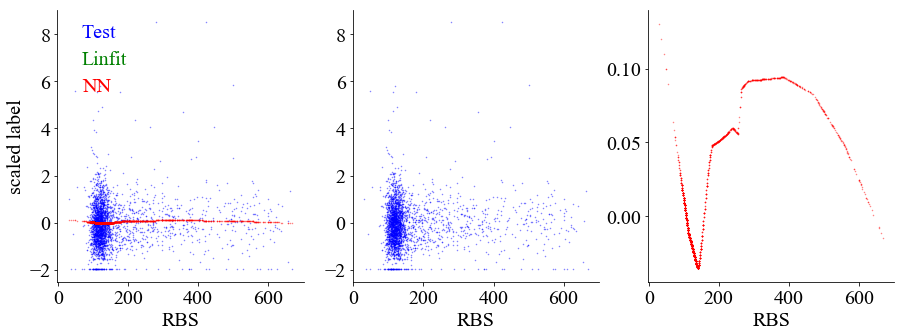

In [30]:
f,a = plt.subplots(ncols=3, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
a[1].scatter(Xtrue, Ytrue, 1, marker='.', c='b', alpha=0.5)
a[2].scatter(Xtrue, Ypred, 1, marker='.', c='r', alpha=0.5)
# a[2].scatter(Xtrue, ypredlinfit_s, 1, marker='.', c='g', alpha=0.5)
a[0].scatter(Xtrue, Ytrue, 1, marker='.', c='b', alpha=0.5)
# a[0].scatter(Xtrue, ypredlinfit_s, 1, marker='.', c='g', alpha=0.5)
a[0].scatter(Xtrue, Ypred, 1, marker='.', c='r', alpha=0.5)

l = ['Test', "Linfit", 'NN']
c = ['b','g','r']
for i,a_i in enumerate(a):
    a[0].text(0.1, .9-i*0.1, l[i], color=c[i], transform=a[0].transAxes)
    a_i.set_xlabel("RBS")
a[0].set_ylabel("scaled label")
#     a_i.set_xscale("log")
plt.savefig("./scaled_ytrue_pred_linfit.pdf", bbox_inches="tight", dpi=256)

In [122]:
p_true = []
x_true = []
y_true = []
y_pred = []
y_base = []
for j,file_i in enumerate(files):
    print(file_i)
    d = np.load(file_i)
    out = d['arr_0'].item()
    p_true.append(out['test'][0])
    x_true.append(out['test'][1])
    y_true.append(out['test'][2].squeeze())
    ybasei = np.ones(out['test'][2].shape[0])*np.mean(out['train'][2])
    print(np.sqrt(np.mean((out['test'][2].squeeze() - ybasei)**2)), ybasei[0])
    y_base.append(ybasei)
    y_avg = []
    for i in range(len(out['chain_y'])):
        y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
    y_pred.append(np.mean(np.array(y_avg), axis=0))

Ptrue = np.concatenate(p_true)
Xtrue = np.concatenate(x_true)
Ytrue = np.concatenate(y_true)
Ybase = np.concatenate(y_base)
Ypred = np.concatenate(y_pred)
print(Xtrue.shape, Ytrue.shape, Ypred.shape, Ybase.shape)

/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel_f8/fold0/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz
1.0 4.934936525184871e-17
(2688, 1) (2688,) (2688,) (2688,)


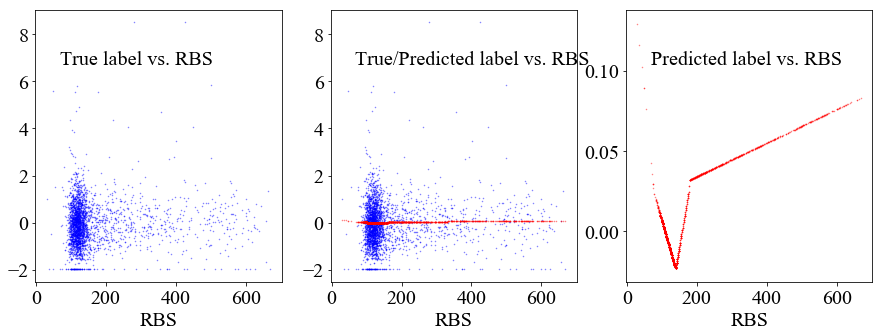

In [41]:
f,a = plt.subplots(ncols=3, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
a[0].scatter(Xtrue, Ytrue, 1, marker='.', c='b', alpha=0.5)
a[2].scatter(Xtrue, Ypred, 1, marker='.', c='r', alpha=0.5)
a[1].scatter(Xtrue, Ytrue, 1, marker='.', c='b', alpha=0.5)
a[1].scatter(Xtrue, Ypred, 1, marker='.', c='r', alpha=0.5)
l = ['True label', "True/Predicted label", 'Predicted label']
for i,a_i in enumerate(a):
    a_i.text(0.1, 0.8, l[i]+" vs. RBS", transform=a_i.transAxes)
    a_i.set_xlabel("RBS")
#     a_i.set_xscale("log")
plt.savefig("./scaled_ytrue_pred.pdf", bbox_inches="tight", dpi=256)

In [101]:
for i in range(4):
    for l in ['train','test']:
        print(i, l, data4fold[l]['fold'+str(i)].size)

0 train 8063
0 test 2688
1 train 8063
1 test 2688
2 train 8063
2 test 2688
3 train 8064
3 test 2687


4.0 0.0


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <a list of 10 Patch objects>)

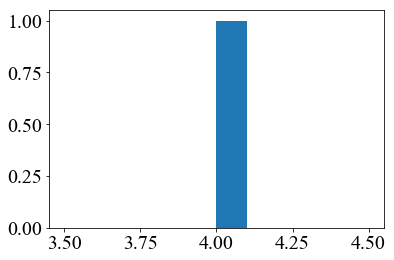

In [103]:
x = np.random.normal(2, 3, size=100)
x = np.random.randint(1,10)
print(np.mean(x), np.std(x))
plt.hist(x)


In [104]:
for sample in data4fold.keys():
    for fold_i in data4fold[sample].keys():
        print("======================== ")
        print(sample, fold_i, np.mean(data4fold[sample][fold_i]['label']), np.std(data4fold[sample][fold_i]['label']))
        data4fold[sample][fold_i]['label'] = norm_it(data4fold[sample][fold_i]['label'])
        print(sample, fold_i, np.mean(data4fold[sample][fold_i]['label']), np.std(data4fold[sample][fold_i]['label']))

test fold0 0.04538690476190476 0.7019484992097358
3.898997526957395e-17
test fold0 0.05803571428571429 0.80524379547629
test fold1 0.020833333333333332 0.7331523721530544
-2.64338815386942e-18
test fold1 0.033482142857142856 0.8107780762741655
test fold2 0.029389880952380952 0.726486110143159
8.591011500075616e-18
test fold2 0.04055059523809524 0.8399838755182137
test fold3 0.03163379233345739 0.7392225589650181
2.3138254327878215e-17
test fold3 0.04242649795310755 0.8796511512157877
train fold0 0.0336103187399231 0.710989165811067
2.6437159956347522e-18
train fold0 0.04564058042912068 0.8397010702843581
train fold1 0.020587870519657697 0.7136609628693228
3.613078527367494e-17
train fold1 0.031625945677787426 0.839828903029602
train fold2 0.031129852412253505 0.7060260812215549
9.253005984721632e-18
train fold2 0.04452437058166935 0.8356896840585136
train fold3 0.030009920634920636 0.6962143951604025
1.76225876924628e-18
train fold3 0.044270833333333336 0.8184076523221568


In [93]:
data4fold[sample][fold_i]['label']

array([-1,  5, -1, ...,  0,  0,  1])

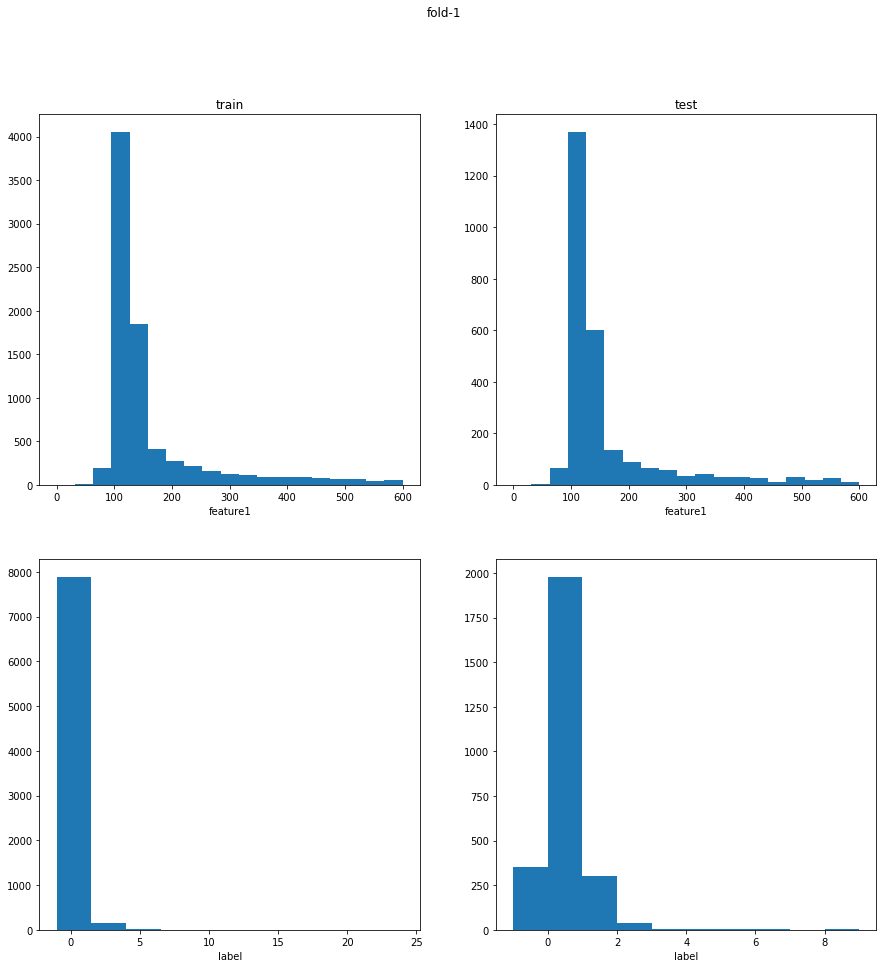

In [41]:
f,a = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
a = a.flatten()
i = 0
plt.suptitle('fold-1')
for l in ['train', 'test']:
    a[i].hist(data4fold[l]['fold0']['features'], bins=np.linspace(0,600, 20), label=l)
    a[i+2].hist(data4fold[l]['fold0']['label'], label=l)
    a[i+2].set_xlabel("label")
    a[i].set_xlabel('feature1')
    a[i].set_title(l)
    i+=1
# data4fold['train']['fold0']

In [ ]:
address = "/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/"
config = {'nchain':10, 'nepoch':500, 'batchsize':200, 'Units':(3,3)}
for i in [0, 1, 2, 3]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold0/
fold1  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold1/
fold2  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize200units33-Lrate0.001 under /Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold2/
fold3  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5


In [79]:
# reading files
#files = glob("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/fold*/reg-nepoch500-nchain10-batchsize200units33.npz")
files = glob("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold*/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz")
files

['/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold0/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold1/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold2/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz',
 '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold3/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz']

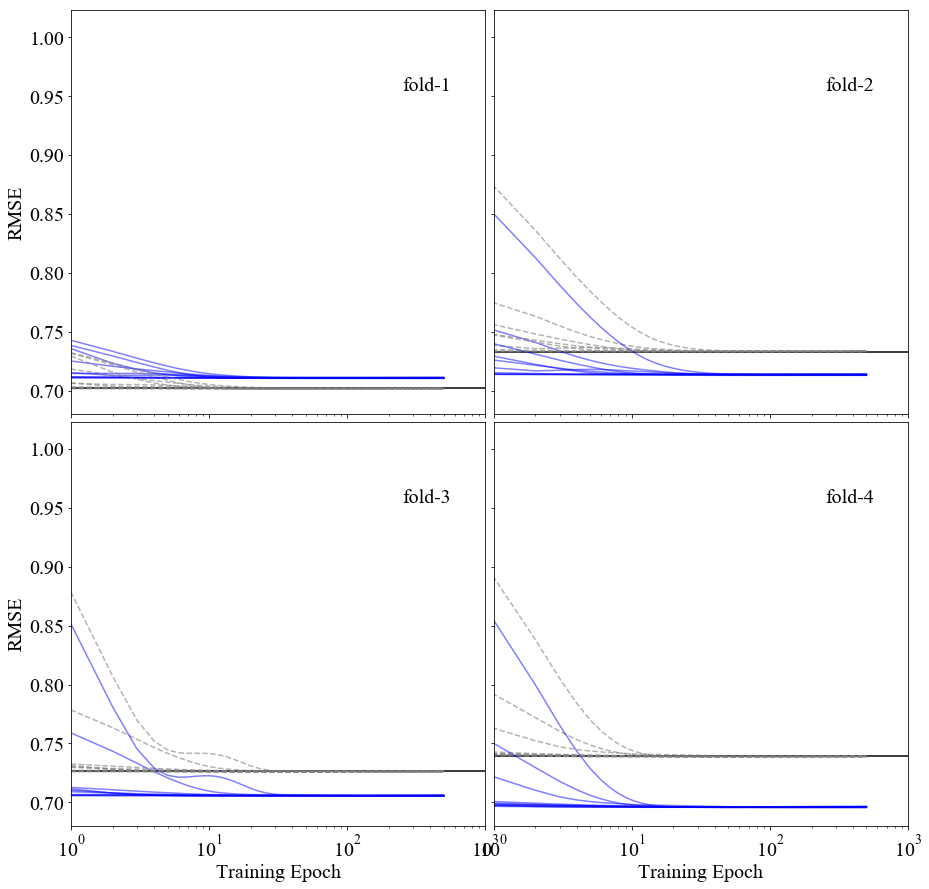

In [46]:
"""
    Plotting the RMSE for 4 different folds

"""
plt.rc('font', size=20, family='Times New Roman')
f, ax = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.flatten()
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=rmse[2],linestyles='-', label='Baseline', alpha=1., color='k')
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.5)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.8, 0.8, "fold-"+str(j+1), transform=ax[j].transAxes)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    #ax[j].set_ylim(3.5, 4.5)
    ax[j].set_xlim(1, 1000)
    #ax[j].set_yscale('log')

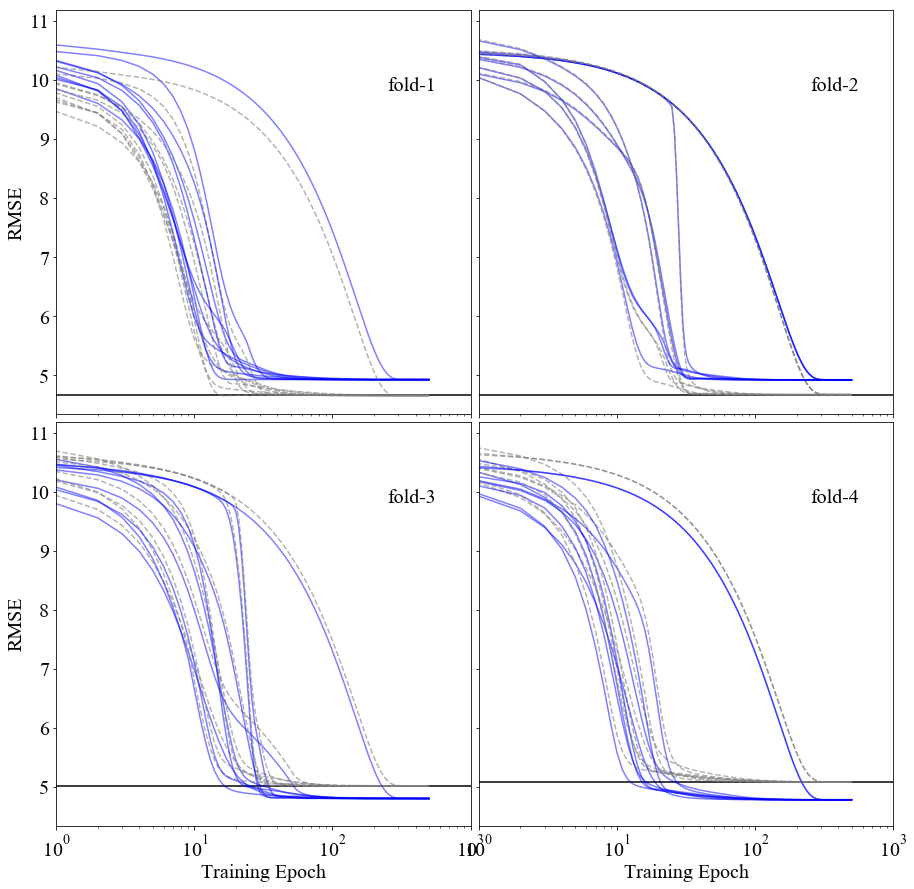

In [10]:
"""
    Plotting the RMSE for 4 different folds

"""
plt.rc('font', size=20, family='Times New Roman')
f, ax = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.flatten()
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=rmse[2],linestyles='-', label='Baseline', alpha=1., color='k')
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.5)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.8, 0.8, "fold-"+str(j+1), transform=ax[j].transAxes)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    #ax[j].set_ylim(3.5, 4.5)
    ax[j].set_xlim(1, 1000)
    #ax[j].set_yscale('log')

In [80]:
"""
    Reading the Ngal and systematic
"""
p_true = []
x_true = []
y_true = []
y_pred = []
y_base = []
for j,file_i in enumerate(files[1:2]):
    print(file_i)
    d = np.load(file_i)
    out = d['arr_0'].item()
    p_true.append(out['test'][0])
    x_true.append(out['test'][1])
    y_true.append(out['test'][2].squeeze())
    ybasei = np.ones(out['test'][2].shape[0])*np.mean(out['train'][2])
    print(np.sqrt(np.mean((out['test'][2].squeeze() - ybasei)**2)), ybasei[0])
    y_base.append(ybasei)
    y_avg = []
    for i in range(len(out['chain_y'])):
        y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
    y_pred.append(np.mean(np.array(y_avg), axis=0))

Ptrue = np.concatenate(p_true)
Xtrue = np.concatenate(x_true)
Ytrue = np.concatenate(y_true)
Ybase = np.concatenate(y_base)
Ypred = np.concatenate(y_pred)
print(Xtrue.shape, Ytrue.shape, Ypred.shape, Ybase.shape)

/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/scaledlabel/fold1/reg-nepoch500-nchain10-batchsize200units33-Lrate0.001.npz
0.7331524132440973 0.020587870519657697
(2688, 1) (2688,) (2688,) (2688,)


In [57]:
np.min(Ytrue)

-2

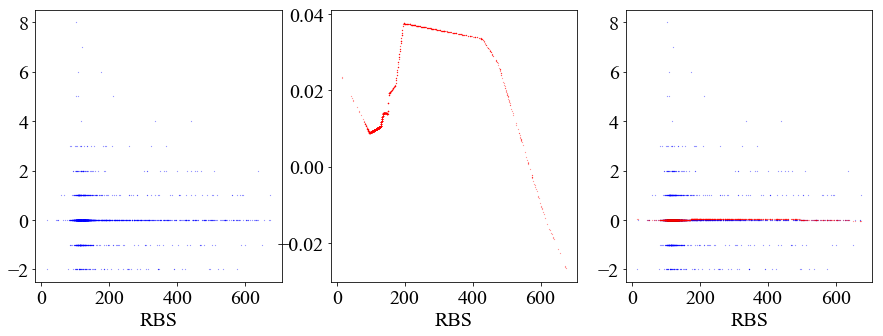

In [85]:
f,a = plt.subplots(ncols=3, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
a[0].scatter(Xtrue, Ytrue, 0.1, marker='.', c='b')
a[1].scatter(Xtrue, Ypred, 0.1, marker='.', c='r')
a[2].scatter(Xtrue, Ytrue, 0.1, marker='.', c='b')
a[2].scatter(Xtrue, Ypred, 0.1, marker='.', c='r')
for a_i in a:
    a_i.set_xlabel("RBS")
plt.savefig("./scaled_ytrue_pred.pdf", bbox_inches="tight", dpi=256)

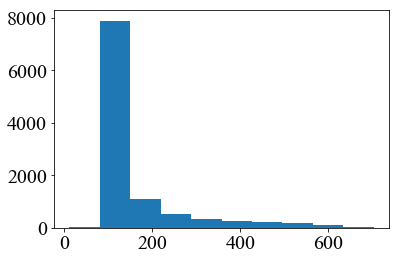

In [12]:
_=plt.hist(Xtrue)

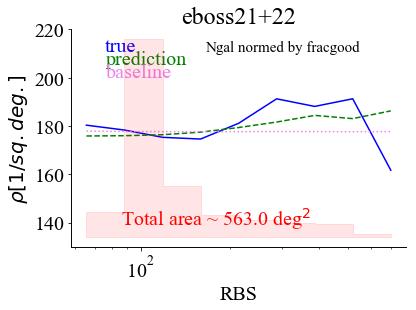

In [30]:
nside2pixarea =lambda nside: 4.*np.pi / (12*nside*nside) * 3282.80635
def get_nsys(sys, ngal):
    bins = np.logspace(np.log10(56.), np.log10(800), 10)
    #bins = np.linspace(70., 800, 20)
    #bins = np.logspace(np.log10(70.), np.log10(800), 20)
    npix,_ = np.histogram(sys, bins=bins)
    ngalp,_ = np.histogram(sys, bins=bins, weights=ngal)
    area = nside2pixarea(nside=256)
    avg  = np.sum(ngalp)/np.sum(npix)/area
#     return bins[:-1], ngalp/npix/area/avg - 1, area*npix
    return 0.5*(bins[:-1]+bins[1:]), ngalp/npix/area, area*npix

xl=[]
y1l =[]
y2l = []
for x,y in [(Xtrue[:,0], Ytrue),(Xtrue[:,0], Ypred), (Xtrue[:,0], Ybase)]:
    #print(x.shape, y.shape)
    x, y, a = get_nsys(x, y)
    xl.append(x)
    y1l.append(y)
    y2l.append(a)

plt.rc('axes.spines', right=False, top=False)
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
lt = ['-','--',':']
c  = ['blue', 'green','violet']
for i, label_i in enumerate(['true', 'prediction','baseline']):
    ax1.plot(xl[i], y1l[i], ls=lt[i], color=c[i] )
    ax1.text(0.1, 0.9-i*0.06, label_i, color=c[i], transform=ax1.transAxes)
    
    
ax1.set_title('eboss21+22')
ax2.fill_between(xl[0], y2l[0], color='red', alpha=0.1, step='pre')
ax1.set_ylabel(r'$\rho [1/sq. deg.]$')
ax2.text(0.15, 0.1, r'Total area ~ {:.1f} deg$^{}$'.format(np.sum(y2l[0]),2),
         transform=ax2.transAxes, fontsize=20, color='r')
ax2.text(0.4, 0.9, "Ngal normed by fracgood", color='k', transform=ax2.transAxes, fontsize=15)
ax2.set_yticks([])
ax1.set_xlabel(r'RBS')
ax1.set_ylim(130, 220)
# ax2.set_ylim(0, 500)
ax1.set_xscale('log')
# ax1.set_xlim(xmin=0.009, xmax=0.3)
# plt.savefig('./density_ebv.pdf', bbox_inches='tight')

In [ ]:
d = np.load(files[0])
out = d['arr_0'].item()
y_true = out['test'][2].squeeze()
y_avg = []
for i in range(len(out['chain_y'])):
    y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
y_pred = np.mean(np.array(y_avg), axis=0)
sq_err = (y_pred-y_true)*(y_pred-y_true)
print(np.sqrt(np.mean(sq_err)), sq_err.shape, y_pred.size, y_true.size, y_true.shape, y_pred.shape)

In [82]:
y_pred.shape, y_true.shape, y_pred[:,np.newaxis].shape, (y_pred[:,np.newaxis] - y_true[:,]).shape

((2688,), (2688,), (2688, 1), (2688, 2688))

In [ ]:
plt.scatter(np.arange(sq_err.size), sq_err, s=2.,alpha=0.2)

In [77]:
(sq_err > 1500).sum() , sq_err.size

(2, 2688)

In [ ]:
#
import fitsio as ft
nside2pixarea =lambda nside: 4.*np.pi / (12*nside*nside) * 3282.80635
ran_exp   = 10000 * nside2pixarea(256) # Nran per pixel
path2cats = '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.6,1.1),
              sysweight=None,
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7zp75',
              path4kpks=path2cats+analysis
             )
gal = []
for i in [1, 2]:
    gal.append(ft.read(g(str(i)), lower=True, columns=kwargs['galcolnames']))
gal = np.concatenate(gal)
galmask = (gal['sector_tsr'] > kwargs['tsrmin']) & (gal['sector_ssr'] > kwargs['ssrmin'])
galmask &= (gal['z'] > kwargs['zlim'][0]) & (gal['z'] < kwargs['zlim'][1])
galmask &= (gal['z_reliable']) & (~gal['isdupl'])
gal = gal[galmask]

ranmap    = ft.read('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits')
linselect = ft.read("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/selection_rbsfit.fits")
fracgood = ranmap / ran_exp

In [ ]:
Ypredlinfit = linselect[Ptrue]*ranmap[Ptrue]*
randfit_m_normed = randfit_masked * (Ytrue.sum()/randfit_masked.sum())
randAI = np.copy(Ypred)
randAInorm = randAI * (Ytrue.sum()/randAI.sum())

In [ ]:
get_rmse = lambda yobs: np.sqrt(np.mean( (Ytrue - yobs)**2))
print("RMSE of \nNN random (normed): {:.3f}  linear fit random (normed) : {:.3f}"\
      .format(get_rmse(randAInorm), get_rmse(randfit_m_normed)))

In [7]:
address = "/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/"
config = {'nchain':10, 'nepoch':500, 'batchsize':200, 'Units':(2,2)}
for i in [0]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize200units22 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/


In [9]:
files = glob.glob("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/*.npz")
files

['/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units11.npz',
 '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units22.npz']

/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units11.npz
/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units22.npz


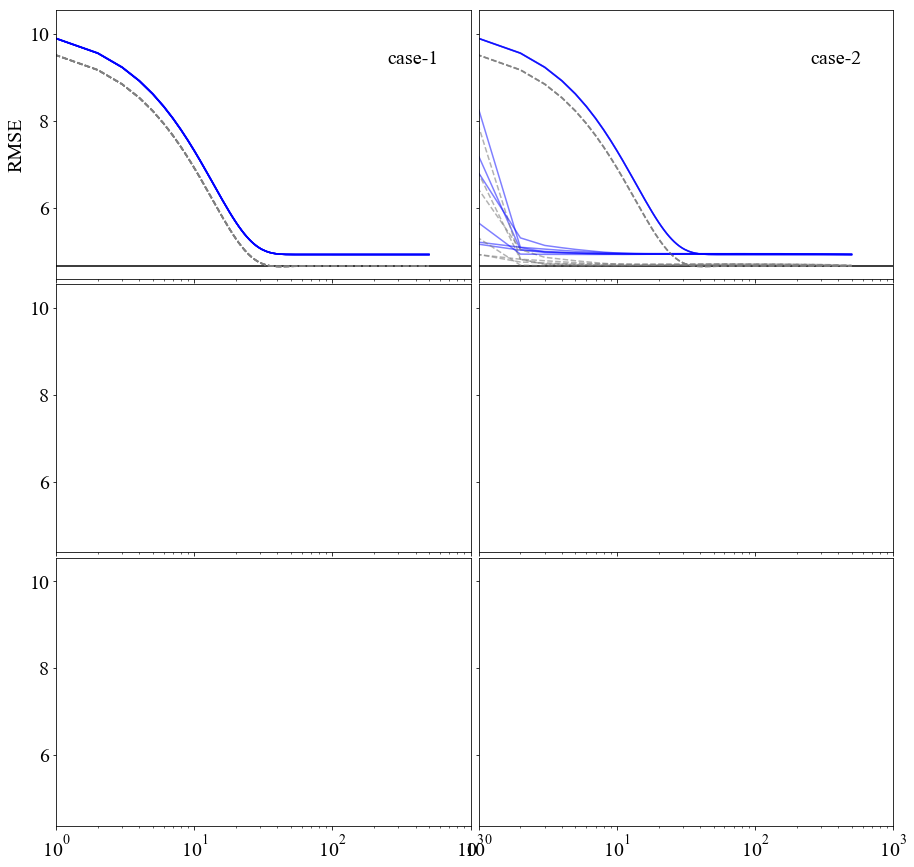

In [12]:
plt.rc('font', size=20, family='Times New Roman')
f, ax = plt.subplots(3, 2, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.flatten()
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=rmse[2],linestyles='-', label='Baseline', alpha=1., color='k')
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.5)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.8, 0.8, "case-"+str(j+1), transform=ax[j].transAxes)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
#     ax[j].set_ylim(3.5, 4.5)
    ax[j].set_xlim(1, 1000)
#     ax[j].set_yscale('log')
for f in files:
    print(f)

# Ngal not normalized to fracgood

In [1]:
%matplotlib inline
# tools
import sys
sys.path.append('/Users/mthecosmologist/Dropbox/github/DESILSS')
import numpy as np
import matplotlib.pyplot as plt
import nn

/Users/mthecosmologist/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngal-rbs-eboss21p2.npy')

In [3]:
data

array([(357891,   86., 0), (357892,  102., 0), (357893,  124., 3), ...,
       (427645,  113., 1), (427646,  133., 1), (427647,  101., 1)],
      dtype=[('hpix', '<i8'), ('features', '<f8'), ('label', '<i8')])

In [4]:
data.size

10751

In [18]:
Data4fold = nn.split2kfolds(data, k=4)

In [20]:
nn.write("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs/",
         "ngal-rbs-eboss21p2-4fold", Data4fold, fmt='npy')

In [21]:
dfile = np.load("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngal-rbs-eboss21p2-4fold.npy")
data4fold = dfile.item()

In [74]:
address = "/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/"
# learning_rate=0.005, batchsize=2000, nepoch=500
config = {'nchain':10, 'nepoch':500, 'batchsize':200}
for i in [0,1,2,3]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/
fold1  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold1/
fold2  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold2/
fold3  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold3/


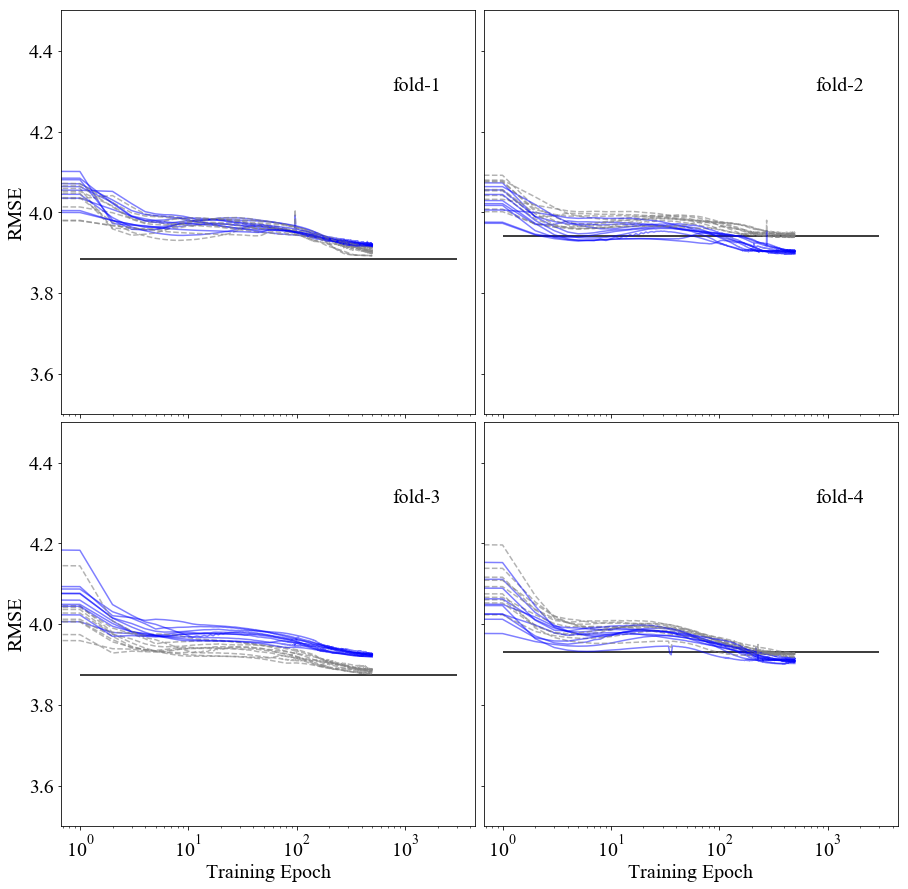

In [4]:
plt.rc('font', size=20, family='Times New Roman')
f, ax = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.flatten()
for j in range(4):
    d = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold'+str(j)+'/reg-nepoch500-nchain10.npz')
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=rmse[2],linestyles='-', label='Baseline', alpha=1., color='k')
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.5)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.8, 0.8, "fold-"+str(j+1), transform=ax[j].transAxes)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    ax[j].set_ylim(3.5, 4.5)
#     ax[j].set_xlim(1, 1000)
#     ax[j].set_yscale('log')

In [5]:
x_true = []
y_true = []
y_pred = []
for i in [0,1,2,3]:
    fold_i = 'fold'+str(i)
    d = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/'+fold_i+'/reg-nepoch500-nchain10.npz')
    out = d['arr_0'].item()
    x_true.append(out['test'][1])
    y_true.append(out['test'][2])
    y_avg = []
    for i in range(len(out['chain_y'])):
        y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
    y_pred.append(np.mean(np.array(y_avg), axis=0))

In [6]:
Xtrue = np.concatenate(x_true)
Ytrue = np.concatenate(y_true).squeeze()
Ypred = np.concatenate(y_pred)

In [7]:
Xtrue[:,0].max()

703.0

In [8]:
nside2pixarea =lambda nside: 4.*np.pi / (12*nside*nside) * 3282.80635
def get_nebv(ebv, ngal):
    bins = np.logspace(np.log10(70.), np.log10(800), 20)
#     bins = np.linspace(0.99*np.min(ebv), 1.01*0.25, 11)
    npix,_ = np.histogram(ebv, bins=bins)
    ngalp,_ = np.histogram(ebv, bins=bins, weights=ngal)
    area = nside2pixarea(nside=256)
    avg  = np.sum(ngalp)/np.sum(npix)/area
#     return bins[:-1], ngalp/npix/area/avg - 1, area*npix
    return 0.5*(bins[:-1]+bins[1:]), ngalp/npix/area, area*npix

xl=[]
y1l =[]
y2l = []
for x,y in [(Xtrue[:,0], Ytrue),(Xtrue[:,0], Ypred)]:
    #print(x.shape, y.shape)
    x, y, a = get_nebv(x, y)
    xl.append(x)
    y1l.append(y)
    y2l.append(a)

/Users/mthecosmologist/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


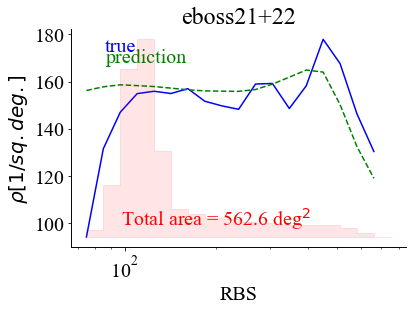

In [12]:
plt.rc('axes.spines', right=False, top=False)
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
lt = ['-','--']
c  = ['blue', 'green']
for i, label_i in enumerate(['true', 'prediction']):
    ax1.plot(xl[i], y1l[i], ls=lt[i], color=c[i] )
    ax1.text(0.1, 0.9-i*0.05, label_i, color=c[i], transform=ax1.transAxes)
    
    
ax1.set_title('eboss21+22')
ax2.fill_between(xl[0], y2l[0], color='red', alpha=0.1, step='pre')
ax1.set_ylabel(r'$\rho [1/sq. deg.]$')
ax2.text(0.15, 0.1, r'Total area = {:.1f} deg$^{}$'.format(np.sum(y2l[0]),2),
         transform=ax2.transAxes, fontsize=20, color='r')
ax2.set_yticks([])
ax1.set_xlabel(r'RBS')
# ax1.set_ylim(1000, 3000)
# ax2.set_ylim(0, 500)
ax1.set_xscale('log')
# ax1.set_xlim(xmin=0.009, xmax=0.3)
# plt.savefig('./density_ebv.pdf', bbox_inches='tight')

# different number of neurons

In [2]:
%matplotlib inline
# tools
import sys
sys.path.insert(0,'/Users/mthecosmologist/Dropbox/github/DESILSS')
import numpy as np
import matplotlib.pyplot as plt
import nn

In [3]:
dfile = np.load("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngal-rbs-eboss21p2-4fold.npy")
data4fold = dfile.item()

In [4]:
address = "/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/"
config = {'nchain':10, 'nepoch':500, 'batchsize':200, 'Units':(2,2)}
for i in [0]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize200units22 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/


In [7]:
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/

reg-nepoch500-nchain10-2000.npz
reg-nepoch500-nchain10-batchsize100units22.npz
reg-nepoch500-nchain10-batchsize200units22.npz
reg-nepoch500-nchain10.npz


In [6]:
config = {'nchain':10, 'nepoch':500, 'batchsize':100, 'Units':(2,2)}
for i in [0]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize100units22 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/


In [16]:
config = {'nchain':10, 'nepoch':500, 'batchsize':50, 'Units':(2,2)}
for i in [0]:
    fold_i = 'fold'+str(i)
    print(fold_i, ' is being processed')
    nn.run_nchainlearning(address+fold_i+'/',
                       data4fold['train'][fold_i], 
                       data4fold['test'][fold_i],
                      **config)

fold0  is being processed
chain  0
chain  1
chain  2
chain  3
chain  4
chain  5
chain  6
chain  7
chain  8
chain  9
output is saved as reg-nepoch500-nchain10-batchsize50units22 under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/


In [8]:
import glob

In [21]:
files = glob.glob("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/*.npz")
files

['/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize100units22.npz',
 '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize2000units1010.npz',
 '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units1010.npz',
 '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units22.npz',
 '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize50units22.npz']

/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize100units22.npz
/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize2000units1010.npz
/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units1010.npz
/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize200units22.npz
/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/fold0/reg-nepoch500-nchain10-batchsize50units22.npz


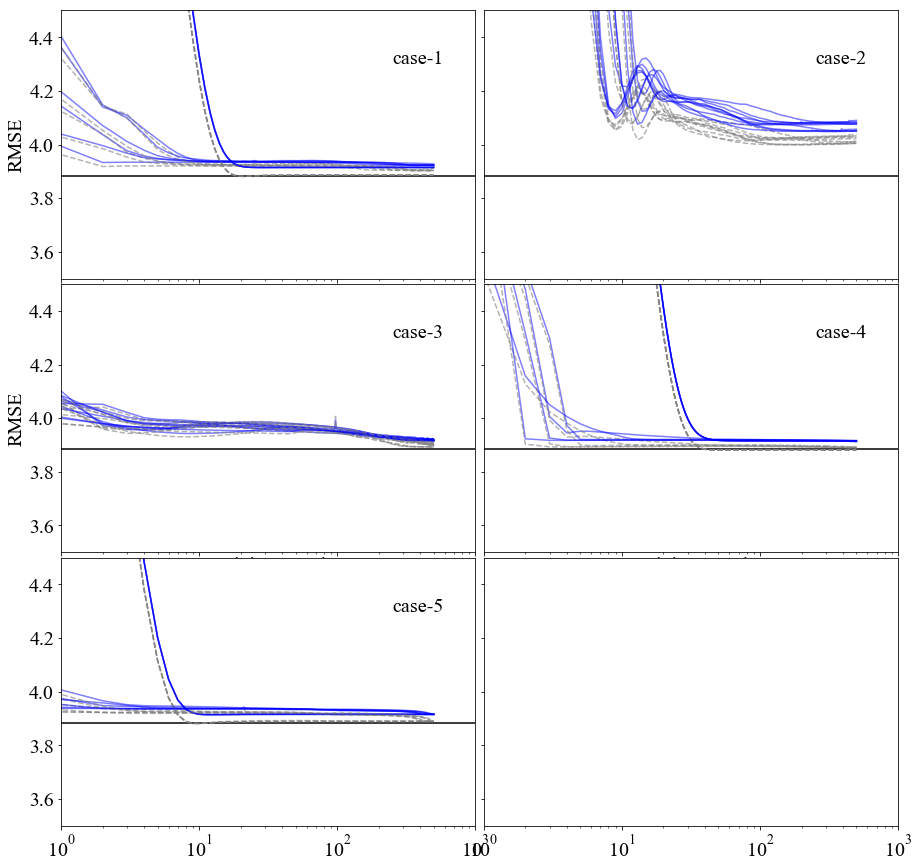

In [24]:
plt.rc('font', size=20, family='Times New Roman')
f, ax = plt.subplots(3, 2, figsize=(15,15), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.flatten()
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,rmse in enumerate(out['epoch_RMSEs']):
        if i == 0:
            ax[j].hlines(xmin=1,xmax=3000,y=rmse[2],linestyles='-', label='Baseline', alpha=1., color='k')
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,1],ls='-',c='blue', alpha=0.5)
        ax[j].plot(rmse[-1][:,0], rmse[-1][:,2],ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.8, 0.8, "case-"+str(j+1), transform=ax[j].transAxes)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    ax[j].set_ylim(3.5, 4.5)
    ax[j].set_xlim(1, 1000)
#     ax[j].set_yscale('log')
for f in files:
    print(f)

In [31]:
d = np.load(files[2])
out = d['arr_0'].item()

In [32]:
out

{'chain_y': [[0, array([[ 8.33550453],
          [ 8.3435421 ],
          [ 8.35160255],
          ..., 
          [ 8.34891987],
          [ 8.34623718],
          [ 8.36770058]], dtype=float32)], [1, array([[ 8.33551979],
          [ 8.32897186],
          [ 8.36912346],
          ..., 
          [ 8.36352348],
          [ 8.3579216 ],
          [ 8.40272522]], dtype=float32)], [2, array([[ 8.28241062],
          [ 8.23412418],
          [ 8.28241062],
          ..., 
          [ 8.28241062],
          [ 8.28241062],
          [ 8.28241062]], dtype=float32)], [3, array([[ 8.31040001],
          [ 8.31268406],
          [ 8.35892963],
          ..., 
          [ 8.35084152],
          [ 8.34275341],
          [ 8.39703083]], dtype=float32)], [4, array([[ 8.21073341],
          [ 8.12196159],
          [ 8.21073341],
          ..., 
          [ 8.21073341],
          [ 8.21073341],
          [ 8.21073341]], dtype=float32)], [5, array([[ 8.3650589 ],
          [ 8.37487411],
          [

# working with nbodykit env

In [1]:
# tools
import matplotlib.pyplot as plt
import healpy as hp
import fitsio as ft
import numpy as np
import sys
sys.path.append('/Users/mthecosmologist/Dropbox/github/DESILSS')
from syslss import ngalsys

In [7]:
# random
ranmap1 = ft.read('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits')

In [27]:
p_true = []
x_true = []
y_true = []
y_pred = []
for i in [0,1,2,3]:
    fold_i = 'fold'+str(i)
    try:
        d = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/'+fold_i+'/reg-nepoch500-nchain10-batchsize200units1010.npz')
    except:
        d = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/'+fold_i+'/reg-nepoch500-nchain10.npz')
    out = d['arr_0'].item()
    p_true.append(out['test'][0])
    x_true.append(out['test'][1])
    y_true.append(out['test'][2])
    y_avg = []
    for i in range(len(out['chain_y'])):
        y_avg.append(out['chain_y'][i][1].squeeze().tolist())    
    y_pred.append(np.mean(np.array(y_avg), axis=0))
Ptrue = np.concatenate(p_true)
Xtrue = np.concatenate(x_true)
Ytrue = np.concatenate(y_true).squeeze()
Ypred = np.concatenate(y_pred)

In [30]:
Ypred

5.3331679821014406

In [4]:
class systematic(object):
    def __init__(self, sysname, mask):
        df = sysname #ft.read(sysname, lower=True)
        self.HPIX = np.argwhere(~np.logical_not(mask)).flatten()
        self.SIGNAL = df[~np.logical_not(mask)]
        
mask = np.zeros(12*256**2)
mask[Ptrue] = 1.0
rbs  = np.zeros(12*256**2)
rbs[Ptrue]  = Xtrue[:,0]
ranmap2 = np.zeros(12*256**2)
ranmap2[Ptrue] = Ypred
galmap = np.zeros(12*256**2)
galmap[Ptrue] = Ytrue

rbs256 = systematic(rbs, mask)

In [6]:
#
#
dr3 = ngalsys(galmap, 256,hpmap=True)
dr3.prepare_inputs(rbs256, selection_function=ranmap1, fracdet_c=-5000)
dr3.digitize_ngalsys(np.logspace(1.8, 3, 16))
dr3.processjack()
#
#
dr3ai = ngalsys(galmap, 256,hpmap=True)
dr3ai.prepare_inputs(rbs256, selection_function=ranmap2, fracdet_c=-5000)
dr3ai.digitize_ngalsys(np.logspace(1.8, 3, 16))
dr3ai.processjack()

/Users/mthecosmologist/Dropbox/github/DESILSS/syslss.py:327: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(std)/(len(self.sysl[i])-1.)


In [34]:
path2ou = "/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/"
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/

NN/                                 kpks-v05/
delta_ebv.npy                       kpks-v05kpkeboss21Y1v5_10_7v05.npy
delta_rbs.npy                       kpks-v05kpkeboss22Y1v5_10_7v05.npy
delta_rbsfit.npy                    kpks-v05kpkeboss23Y1v5_10_7v05.npy
eboss.tar                           nofz/
eboss21.v5_10_7.latest.fits         nofz_21and22/
eboss21.v5_10_7.latest.rands.fits   nofz_woSSR/
eboss22.v5_10_7.latest.fits         sector_tsr_ssr_mask_p8_p7.fits
eboss22.v5_10_7.latest.rands.fits   selection_rbsfit.fits
eboss23.v5_10_7.latest.fits         test/
eboss23.v5_10_7.latest.rands.fits   test_arnaud_wSSR/
ebossebsai.npy                      v01_04/
ebossrbs.npy                        woSSR/


In [9]:
np.save(path2ou+'ebossrbs', dr3.output)
np.save(path2ou+'ebossebsai', dr3ai.output)

In [35]:
eboss   = np.load(path2ou+'ebossrbs.npy').item()
ebossai = np.load(path2ou+'ebossebsai.npy').item()
ebossfit = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/delta_rbsfit.npy').item()

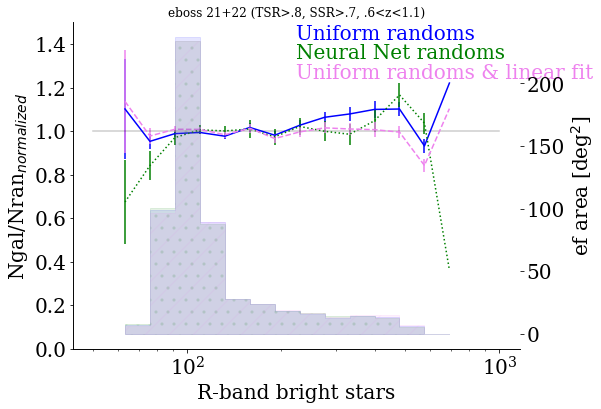

In [37]:
def helper(name):
    x = name['bin_edges'][:-1]
    y = name['delta']
    ye = name['delta_err']
    s = name['area']
    mask = y != 0.0
    x = x[mask]
    y = y[mask]
    ye = ye[mask]
    s  = s[mask]
    return x, y, ye, s
plt.rc('figure', figsize=(8,6))
plt.rc("axes.spines", top=False, right=False)
plt.rc("font",size=20, family='serif')
f,a = plt.subplots()
a2 = a.twinx()
a2.set_ylabel(r'ef area [deg$^{2}$]')
a.set_title("eboss 21+22 (TSR>.8, SSR>.7, .6<z<1.1)", fontsize=12)
a.set_ylabel(r'Ngal/Nran$_{normalized}$')
a.set_xlabel('R-band bright stars')
a.set_xscale('log')
a.set_ylim(0.0, 1.5)
# a.set_xlim(0.01, 0.2)
c = ['b', 'g', 'violet']
l = ['-',':', '--']
h=['','.', '/']
t = ['Uniform randoms','Neural Net randoms', 'Uniform randoms & linear fit']
a.plot([50,1000], [1, 1], 'k-', alpha=0.2)
for i,n in enumerate([eboss, ebossai, ebossfit]):
    x,y,ye,s = helper(n)
    a.errorbar(x, y, yerr=ye, c=c[i], linestyle=l[i])
    a.text(0.5, 0.95-i*0.06, t[i], transform=a.transAxes, color=c[i])
    a2.fill_between(x, s, step='pre', color=c[i], alpha=0.1, hatch=h[i])

In [2]:
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/

NN/                                 kpks-v05/
delta_ebv.npy                       kpks-v05kpkeboss21Y1v5_10_7v05.npy
delta_rbs.npy                       kpks-v05kpkeboss22Y1v5_10_7v05.npy
delta_rbsfit.npy                    kpks-v05kpkeboss23Y1v5_10_7v05.npy
eboss.tar                           nofz/
eboss21.v5_10_7.latest.fits         nofz_21and22/
eboss21.v5_10_7.latest.rands.fits   nofz_woSSR/
eboss22.v5_10_7.latest.fits         sector_tsr_ssr_mask_p8_p7.fits
eboss22.v5_10_7.latest.rands.fits   selection_rbsfit.fits
eboss23.v5_10_7.latest.fits         test/
eboss23.v5_10_7.latest.rands.fits   test_arnaud_wSSR/
ebossebsai.npy                      v01_04/
ebossrbs.npy                        woSSR/


In [3]:
randfit = ft.read("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/selection_rbsfit.fits")

In [5]:
import healpy as hp

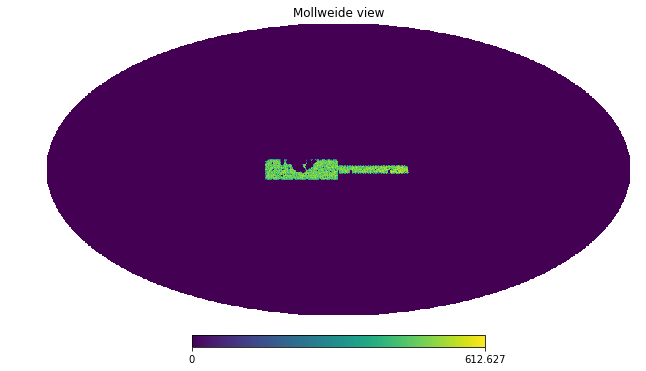

In [8]:
hp.mollview(randfit*ranmap1)

In [7]:
randfit_masked = randfit[Ptrue]*ranmap1[Ptrue]
randfit_m_normed = randfit_masked * (Ytrue.sum()/randfit_masked.sum())
randAI = np.copy(Ypred)
randAInorm = randAI * (Ytrue.sum()/randAI.sum())

NameError: name 'randAI' is not defined

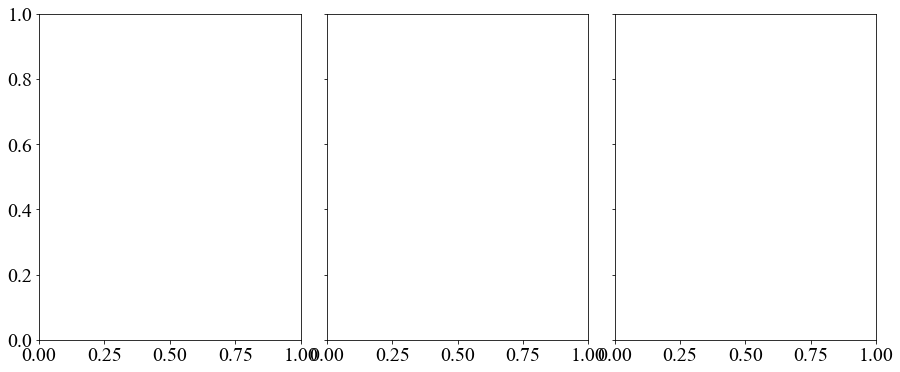

In [28]:

f,a = plt.subplots(ncols=3, sharey=True, figsize=(15,6))
plt.subplots_adjust(wspace=0.1)
l = ['NN random', 'linfit random', 'Ngal True']
b = np.linspace(-10, 25, 20)
for i,s in enumerate([randAI, randfit_m_normed, Ytrue]):
    a[i].hist(s, bins=b, label=l[i])
    a[i].legend()
    a[i].set_xlabel("N")
    a[i].set_yscale('log')

In [8]:
get_rmse = lambda yobs: np.sqrt(np.mean( (Ytrue - yobs)**2))

In [9]:
print("RMSE of \nNN random (normed): {:.3f}  linear fit random (normed) : {:.3f}"\
      .format(get_rmse(randAInorm), get_rmse(randfit_m_normed)))

RMSE of 
NN random (normed): 3.906  linear fit random (normed) : 3.241
